In [70]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
import sys
import importlib
sys.path.append('../src/')
sys.path.append('../data/')
import models_utils as mu
importlib.reload(mu)
#from data_utils import generate_synthethic, transform_and_normalize, CCCscore
import load_rosmap as lr
importlib.reload(lr)
import data_utils as du
importlib.reload(du)
from sklearn.model_selection import train_test_split
import torch
import os
import numpy as np
from tqdm import tqdm
from captum.attr import DeepLift, LayerDeepLift
from collections import defaultdict
import pandas as pd

In [33]:
## lets use the human brain cortex dataset from the original manuscript
scRNA, _ = lr.load_and_filter_hbc_rosmap(genes_cutoff=3000)

## create pseudobulk for train
xtrain, ytrain, celltypes = du.generate_synthethic(scRNA.copy(), nsamples = 5000)

## transform and normalize
xtrain, = du.transform_and_normalize(xtrain)

## convert to torch
xtrain, = du.convert_to_float_tensors(xtrain)

simulating bulk: 100%|██████████| 5022/5022 [00:13<00:00, 378.36it/s]


In [42]:
## save it 
modelpath = f'../data/model_rosmap_weights_{scRNA.shape[1]}_genes.pt'

## load the model
model = mu.SweetWaterAutoEncoder(xtrain.shape[1], num_classes = ytrain.shape[1])
model.load_state_dict(torch.load(os.path.join(modelpath)))
model.eval()

SweetWaterAutoEncoder(
  (encl1): Linear(in_features=3000, out_features=1500, bias=True)
  (encl2): Linear(in_features=1500, out_features=750, bias=True)
  (decl1): Linear(in_features=750, out_features=1500, bias=True)
  (decl2): Linear(in_features=1500, out_features=3000, bias=True)
  (propl1): Linear(in_features=750, out_features=750, bias=True)
  (propl2): Linear(in_features=750, out_features=5, bias=True)
  (relu1): ReLU()
  (relu2): ReLU()
  (relu3): ReLU()
  (smm): Softmax(dim=1)
  (sm): Sigmoid()
)

In [58]:

## define name and number of top genes per cell type
name = 'Human Brain Cortex'
ngenes_ct = 10

## get dict for dynamic references
singlect_dict = du.select_only_1ct_samples(ytrain)

#define samples for static references
input = xtrain

#define the reference
refzeros = torch.zeros(size=input.shape)

"""
Compute scores
"""
output = 0 ## gene i
extra = None
deeplift_scores_l = []

for i in tqdm(range(ytrain.shape[1])):

    ## Calculate scores
    deeplift_score = du.calculate_scores_batch(DeepLift(model), input, refzeros, i, extra) ## output gene i
    ## sum across samples
    score_values = deeplift_score.cpu().detach().numpy().sum(axis=0)
    deeplift_scores_l.append(score_values)

# visualize score
deeplift_scores_df = pd.DataFrame(deeplift_scores_l).T
deeplift_scores_df.columns = celltypes
deeplift_scores_df.index = scRNA.columns

topkdeepliftscore_genes = []
for ct in deeplift_scores_df.columns:
    topkdeepliftscore_genes += deeplift_scores_df.loc[:,ct].sort_values(ascending=False).head(ngenes_ct).index.tolist()
    
deeplift_scores_df_kgenes = deeplift_scores_df.loc[topkdeepliftscore_genes, :]


100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 7.5 mm


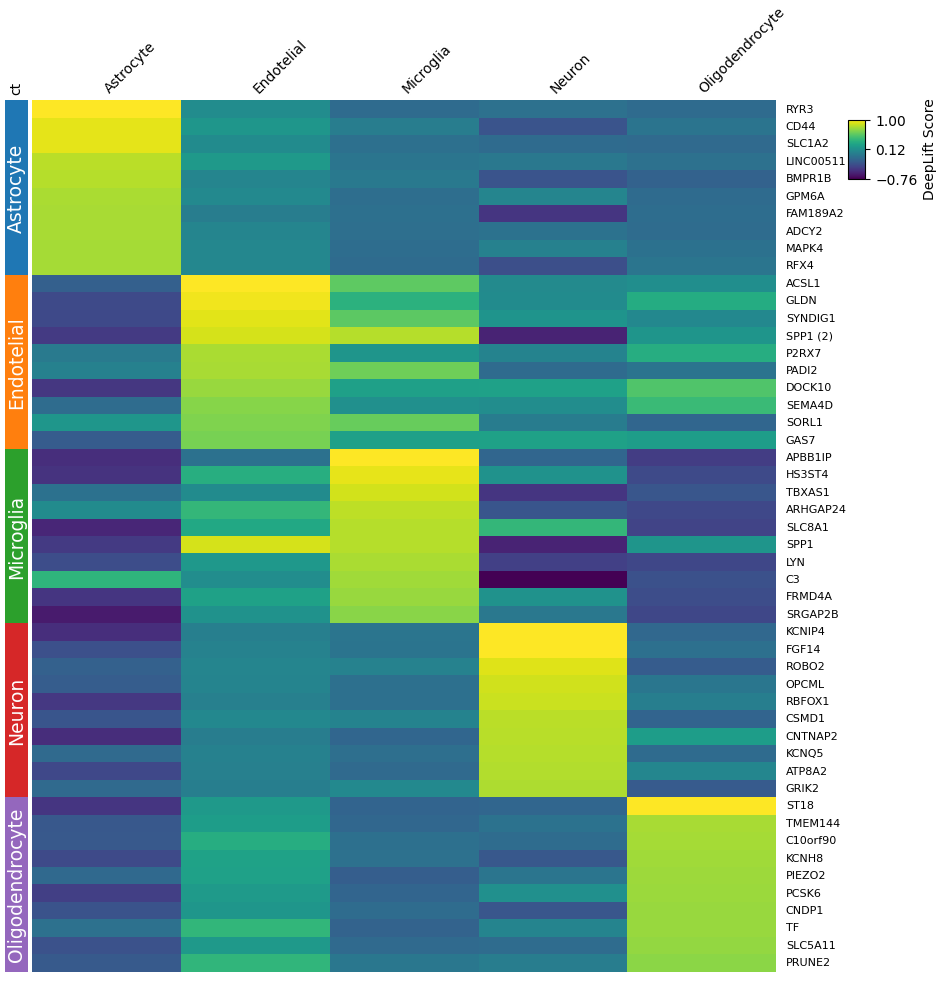

In [71]:
## plot complex heatmap
du.plot_complexheatmap(du.rename_duplicates(deeplift_scores_df_kgenes))

## Note that results from the original manuscript may differ as they have been computed using different number of genes.